In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns to something better
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [10]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [11]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [12]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7141 unique tokens.


In [13]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 121)


In [14]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 121)


In [15]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [16]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.8635 - loss: 0.4718 - val_accuracy: 0.8581 - val_loss: 0.2826
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9101 - loss: 0.1954 - val_accuracy: 0.9782 - val_loss: 0.1019
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9908 - loss: 0.0707 - val_accuracy: 0.9842 - val_loss: 0.0690
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9929 - loss: 0.0444 - val_accuracy: 0.9886 - val_loss: 0.0544
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9937 - loss: 0.0316 - val_accuracy: 0.9891 - val_loss: 0.0480
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9984 - loss: 0.0180 - val_accuracy: 0.9891 - val_loss: 0.0496
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9981 - loss: 0.0156 - val_accuracy: 0.9886 - val_loss: 0.0537
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9986 - loss:

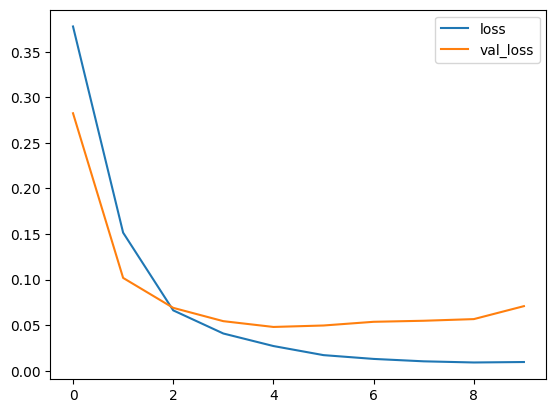

In [17]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

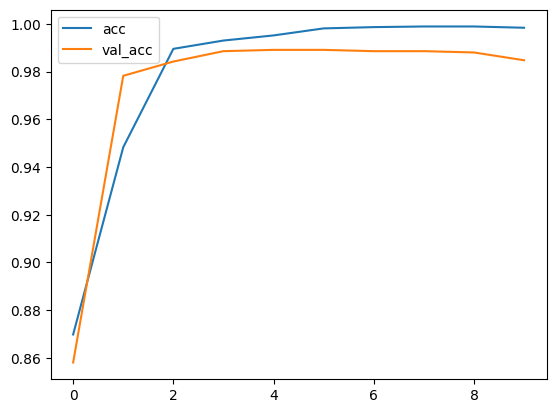

In [18]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()